# Introduction

The Local Ocean Conservation - Sea Turtle Face Detection on Zindi challenges participants to build an algorithm capable of drawing a bounding box around the all-important facial scales of a sea turtle. 

In this notebook we'll look at the data and build a very basic solution.

# Loading the data

I have the files in my Google Drive, which is mounted here in Colab. You can also upload the files directly.

In [31]:
from PIL import Image, ImageDraw
import pandas as pd
from matplotlib import pyplot as plt

In [32]:
# You can choose the 1024px version instead, but these are nice for initial testing
#!cp 'drive/My Drive/sea_turtles/IMAGES_512.zip' .
!unzip -q IMAGES_512.zip
image_folder = './dataset/IMAGES_512'

/bin/bash: /home/alberto/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open IMAGES_512.zip, IMAGES_512.zip.zip or IMAGES_512.zip.ZIP.


In [33]:
# Load train - edit path to suit your setup
train = pd.read_csv('./dataset/Train.csv')
print(train.shape)
train.head()

(1326, 5)


Image_ID         x         y         w         h
0  04FB1B33  0.481988  0.506076  0.174696  0.405671
1  B04E481E  0.617405  0.313368  0.177734  0.293113
2  32655645  0.490885  0.465856  0.165582  0.357350
3  44D4DA7C  0.472873  0.506076  0.237847  0.409722
4  4F36EF72  0.433811  0.574363  0.180773  0.397569

# View an Image

Let's check that we have the images where we expect them, and plot a bounding box to visualize our goal here:

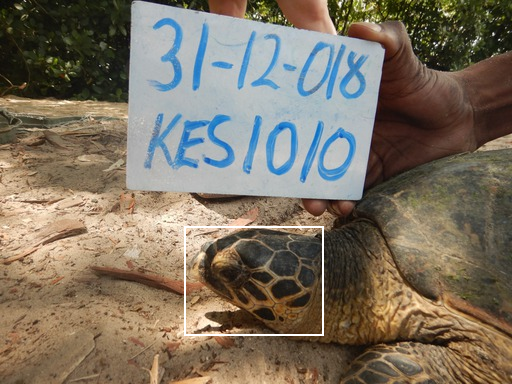

In [34]:
# Take a sample row
imid, x, y, w, h = train.sample().values[0]

# Open with PIL and draw a bounding box
with Image.open(f'{image_folder}/{imid}.JPG') as im:
  imw, imh = im.size # Box coords are relative to image size
  draw = ImageDraw.Draw(im)
  draw.rectangle([int(x*imw), int(y*imh), int((x+w)*imw), int((y+h)*imh)], width=2)
im

## A Useful Library: Keras_Cv

Working with Computer Vision tasks (and object detection in particular) is quite hard.
For this reason, Keras has released a new library: keras_cv.

KerasCV's primary goal is to provide a coherent, elegant, and pleasant API to train state of the art computer vision models relying only on the tensorflow API.
assist in common computer vision tasks such as data-augmentation, classification, object detection, image generation, and more.
It allows to develop training and inference state-of-the art models and pipelines for tasks such as Augmentation, Object Detection, Image Segmentation and Image Classification.

We will use keras_cv for this task

Let us first install keras cv

In [35]:
!pip install git+https://github.com/keras-team/keras-cv

/bin/bash: /home/alberto/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/keras-team/keras-cv to /tmp/pip-req-build-qmyl9f43
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv /tmp/pip-req-build-qmyl9f43
  Resolved https://github.com/keras-team/keras-cv to commit d611c83e73e86a829893eb1d64eb207ecfb4a37b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We now import the libraries we will need in the process

In [36]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import keras_cv
import cv2
import numpy as np
from keras_cv import bounding_box
import pandas as pd

import resource
from keras_cv import visualization
import tqdm

In [37]:
# Checking if the GPU is seen by the jupyter notebook (useful to check the correct installation of all the packages and the drivers for using tensorflow with the GPU).
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Definition of the hyperparameters of the model

In [38]:
# Size of the batch
BATCH_SIZE = 16
# Percentage of the training set to use as training set (the remainder will be used for the size of the validation set)
TRAIN_SPLIT = 0.8
# This value must be defined accordingly to the size that the learner takes in input. For many networks it's usually 224
INPUT_SIZE_LEARNER = 224

## Loading of the dataset

The first step is loading the dataset.
While this may seem a trivial step, when using a pretrained it is really important to be careful to the input desired by the pretrained model (on which kind of data it was trained).

In this case all the models have been pretrained on:
  - images with the 3 channels in the range [0, 255]
  - the location of the bounding boxes are in the range [0, IMG_WIDTH] and [0, IMG_HEIGHT]
  - the data will be a dictionary (useful for plotting later on the images, not required by the model)

In [54]:
def load_dataset(training=True):
    # define the base path to the input dataset and then use it to derive
    # the path to the images directory and annotation CSV file
    BASE_PATH = "dataset"
    IMAGES_PATH = os.path.sep.join([BASE_PATH, "IMAGES_1024"])
    if training:
        ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Train.csv"])
    else:
        ANNOTS_PATH = os.path.sep.join([BASE_PATH, "SampleSubmission.csv"])

    # load the contents of the CSV annotations file
    print("[INFO] loading dataset...")
    rows = open(ANNOTS_PATH).read().strip().split("\n")
    # initialize the list of data (images), our target output predictions
    # (bounding box coordinates), along with the filenames of the
    # individual images
    data = []
    targets = []
    sizes = []

    # Remove the first row containing "ID, x, y, w, h"
    rows = rows[1:]

    for row in rows:
        # Split the fields of the .csv file
        row = row.split(',')
        filename = row[0]
        # Convert the coordinates from strings to floats
        coordinates = [float(v) for v in row[1:]]
        
        imagePath = os.path.sep.join([IMAGES_PATH, filename+'.JPG'])

        # Load the image of the desired size
        image = tf.keras.preprocessing.image.load_img(imagePath, target_size=(INPUT_SIZE_LEARNER, INPUT_SIZE_LEARNER))
        image = tf.keras.preprocessing.image.img_to_array(image)
        
        data.append(image)

        # If training get the coordinates, otherwise get the size for making the prediction as absolute values once you get the offset in range [0,1]
        if training:
            # scale the bounding box coordinates relative to the spatial
            # dimensions of the input image
            startX = coordinates[0] * INPUT_SIZE_LEARNER
            startY = coordinates[1] * INPUT_SIZE_LEARNER
            endX = (coordinates[0]+coordinates[2]) * INPUT_SIZE_LEARNER
            endY = (coordinates[1]+coordinates[3]) * INPUT_SIZE_LEARNER

            targets.append((startX, startY, endX, endY))
        else:
            # derive the path to the input image, load the image (in OpenCV
            # format), and grab its dimensions
            imagePath = os.path.sep.join([IMAGES_PATH, filename+'.JPG'])
            image = cv2.imread(imagePath)
            (img_h, img_w) = image.shape[:2]

            
            sizes.append((img_w, img_h))

    if training:
        dataset = tf.data.Dataset.from_tensor_slices((data, targets))
        dataset = dataset.map(lambda d,t: {'images':d, 'bounding_boxes': {'classes':tf.constant([0]), 'boxes':tf.reshape(t,[1,4])}})
    else:
        dataset = tf.data.Dataset.from_tensor_slices((data, sizes))
    
    print("[INFO] dataset loaded.")
    return dataset, len(data)

In [55]:
# Create the list with the names of the classes associated to the IDs used in the prediction.
# In our case we are predicting only turtles, so that will be the only element in this list
class_ids = ["Turtle"]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Let's now load the data and see if plotting the images results in what we are actually expecting or if we did some mistakes in the definition of the loading methods.

Furthermore, we divide our dataset into training and testing.

In [56]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs['images'], inputs['bounding_boxes']
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

# Load the dataset
dataset, data_size = load_dataset(training=True)

# Splitting the dataset into training and validation
train_size = int(data_size * TRAIN_SPLIT)
val_size = int(data_size * (1 - TRAIN_SPLIT))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)

[INFO] loading dataset...
[INFO] dataset loaded.


Let's batch now our data.
In object detection when using the Keras, it is recommended to use ragged batch of inputs. This is due to the fact that there may be different numbers of bounding boxes per image.

In [57]:
# Shuffle the training set
train_ds = train_ds.shuffle(train_size)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

Finally, we can visualize the dataset.


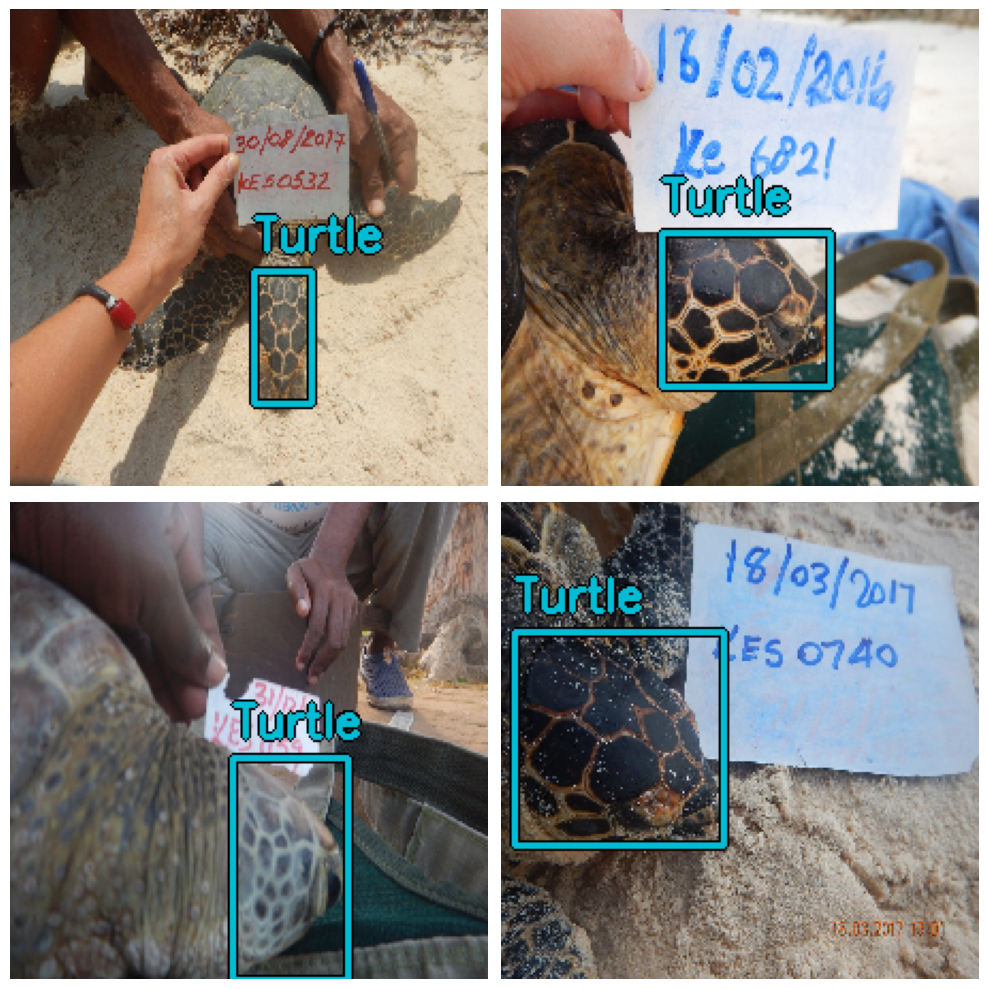

In [58]:
# Visualize the dataset by using the function we defined above.
# The training set
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

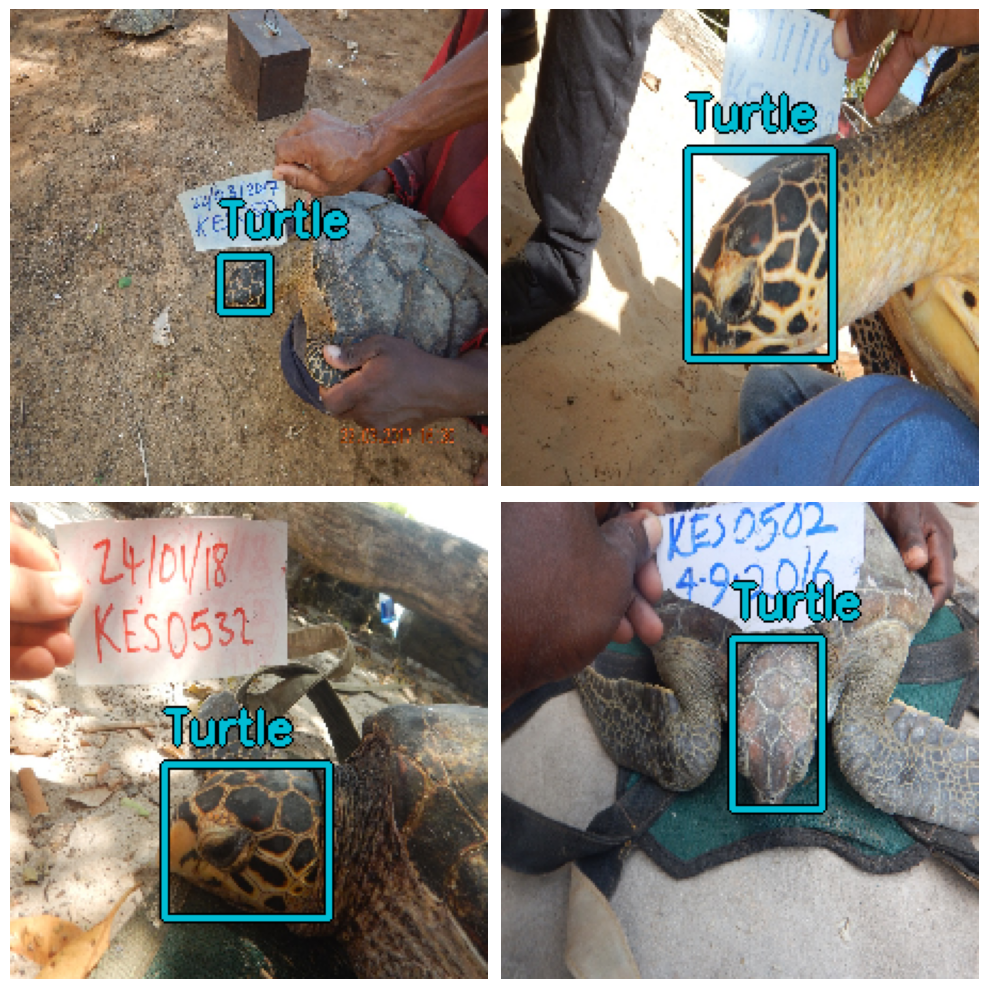

In [59]:
# And validation set
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

## Data Augmentation pipeline

Data Augmentation is the task of artificially generating samples in order to prevent the model from overfitting.
We want to modify the samples in such a way that the network instead of learning by heart the images, will try to understand the actual pattern and how the head of the turtle is done.

For image classification this is easy, while for object detection the task can be quite tedious as the modification of the image implies also the modification of the coordinates of the bounding box.
With keras_cv augmentation is made easier and is handled by the library itself.

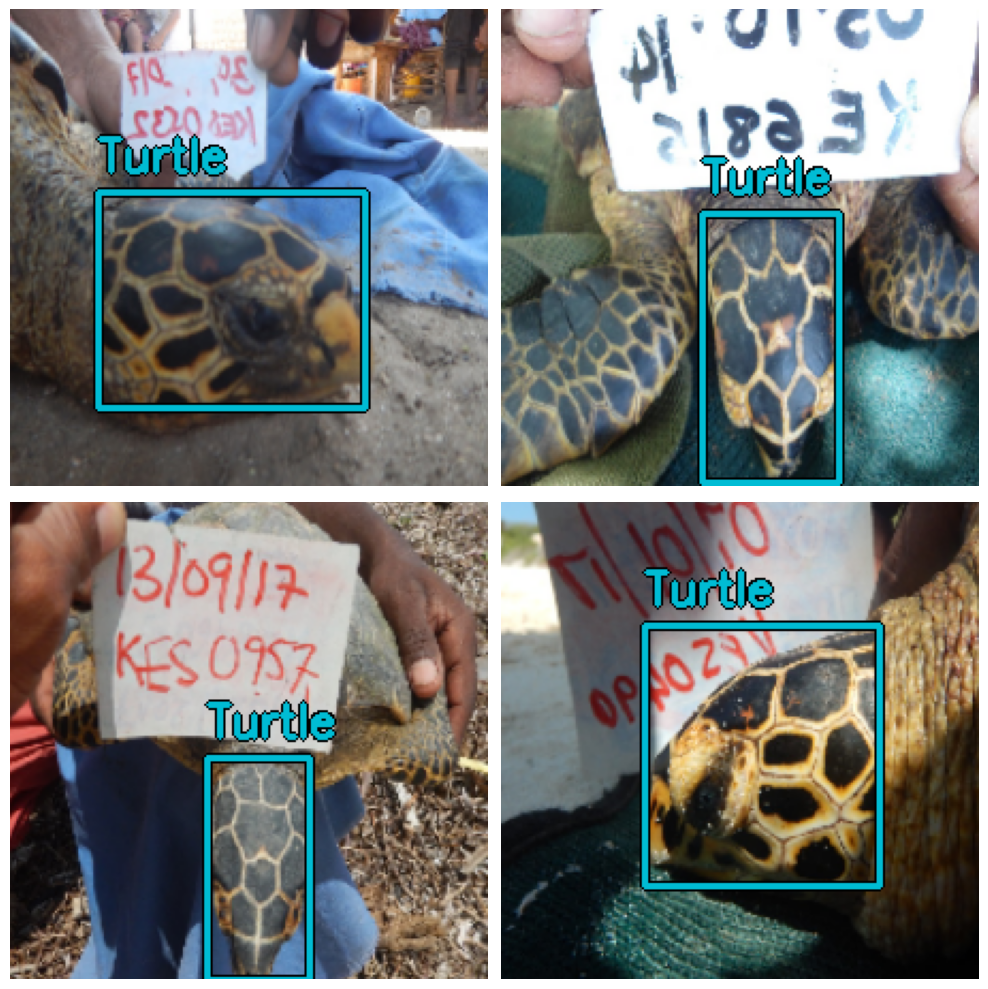

In [60]:
# Augmentation pipeline
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(224, 224), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
        #keras_cv.layers.RandomSaturation((0.4,0.6)),
        #keras_cv.layers.RandomHue(0.1, [0,255])
    ]
)

train_ds_aug = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
#train_ds = train_ds.map(lambda x: {'images':keras_cv.layers.RandomCutout(0.3,0.3)(x['images']), 'bounding_boxes':x['bounding_boxes']})
visualize_dataset(
    train_ds_aug, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

Finally, we unpack the dataset so that it can be processed by the network

In [61]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=1
    )

train_ds = train_ds_aug.map(dict_to_tuple)
val_ds = val_ds.map(dict_to_tuple)
train_ds = train_ds.map(lambda x,y: (x, {'classes': y['classes'], 'boxes':y['boxes'] / 224}))

train = train_ds.prefetch(tf.data.AUTOTUNE)
val = val_ds.prefetch(tf.data.AUTOTUNE)

## Definition of the Model

Once we obtained the dataset, we need to define the hyperparameters of the model that we are going to train

In [62]:
INITIAL_LR = 1e-3
EPOCHS = 20

We need to define the metrics for evaluate the goodness of our training.
The most popular Object Detection metrics are COCO metrics, which were published alongside the MSCOCO dataset. However, in the competition, the Intersection over Union metric is used, so we are going to use it also for our training.

$$IoU = \frac{\text{Area of overlap}}{\text{Area of union}} = \frac{\text{Area of Intersection}}{\text{Ground Truth Area + Predicted Box Area - Intersection Area}}$$

In [63]:
# This function returns the iou for the boxes contained in y_pred and y_true
def compute_iou(y_pred, y_true):
    xA = tf.math.maximum(y_true[:,0], y_pred[:,0])
    yA = tf.math.maximum(y_true[:,1], y_pred[:,1])
    xB = tf.math.minimum(y_true[:,2], y_pred[:,2])
    yB = tf.math.minimum(y_true[:,3], y_pred[:,3])

    # epsilon to add to prevent division by 0
    eps = 1e-5

    inter_area = tf.math.minimum(tf.math.maximum(0, xB - xA + eps),224) * tf.math.minimum(tf.math.maximum(0,yB - yA + eps),224)

    union_area = (y_true[:,2] - y_true[:,0] + eps) * (y_true[:,3] - y_true[:,1] + eps) + (y_pred[:,2] - y_pred[:,0] + eps) * (y_pred[:,3] - y_pred[:,1] + eps) - inter_area

    iou = tf.reduce_sum(inter_area / tf.cast(union_area, tf.float32))

    return iou

# We define a custom callback to compute the validation IoU at the end each epoch
class IouMetricCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        super(IouMetricCallback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        logs['val_iou'] = float('inf')
        iou = 0
        samples = 0
        for image, label in val_ds:
            samples += tf.shape(image)[0]
            pred = model.predict(image)['boxes']
            pred = tf.reshape(pred, [-1,4]) * INPUT_SIZE_LEARNER
            label = label['boxes']
            label = tf.reshape(label, [-1,4])
            iou += compute_iou(pred,label)

        iou = iou / tf.cast(samples, tf.float32)
        logs['val_iou'] = np.round(iou, 5)

Both our training set and the metric we use are ready. Therefore, we have everything needed for starting the training of our network.
We define now models starting from several pre-trained backbones on the imagenet dataset treating object detection as a regression problem.
Differently from the SotA algorithms, the network predicts directly the 4 corners of the bounding box.

This approach has been applied only for educative purposes, since the results will be far from the SotA object detection models.

First of all, we define the number of regression heads and classification heads.

In [64]:
HEAD_BBOX_LAYERS = 3
HEAD_CLASS_LAYERS = 1

Now, we want to define a model that works like this:

1) Uses the backbone to process the input and extracts the features
2) Processes in parallel through the classification and regression heads the output
3) Flattens the output and processes it through some Fully Connected layers that eventually return the 4 corners of the bounding box

We do so by using the functional API of keras

In [65]:
# We are going to use the Functional API of Tensorflow to define a model
class Model(tf.keras.Model):
    
    def __init__(self, backbone:tf.keras.Model):
        
        inputs = tf.keras.layers.Input(shape=[224, 224, 3])
        backbone_res = backbone(inputs)
        
        # Classification Head
        for _ in range(HEAD_CLASS_LAYERS):
            layer = tf.keras.layers.Conv2D(256, 3, padding="same")(backbone_res)
            layer = tf.keras.layers.BatchNormalization()(layer)
            layer = tf.keras.layers.Activation(tf.keras.activations.relu)(layer)
        
        layer = tf.keras.layers.GlobalAveragePooling2D()(layer)
        class_out = tf.keras.layers.Dense(1, activation='sigmoid')(layer)
        
        # Regression head
        for _ in range(HEAD_BBOX_LAYERS):
            layer = tf.keras.layers.Conv2D(256, 3, padding="same")(backbone_res)
            layer = tf.keras.layers.BatchNormalization()(layer)
            layer = tf.keras.layers.Activation(tf.keras.activations.relu)(layer)
            
            
        layer = tf.keras.layers.Conv2D(4, 3, padding="same")(layer)
        
        layer = tf.keras.layers.Flatten()(layer)
        layer = tf.keras.layers.Dense(64, activation='relu')(layer)
        layer = tf.keras.layers.Dropout(0.3)(layer)
        layer = tf.keras.layers.Dense(32, activation='relu')(layer)
        regr_out = tf.keras.layers.Dense(4, activation='sigmoid')(layer)
        regr_out = tf.reshape(regr_out, [-1,1,4])

        super().__init__(inputs=inputs, outputs={'classes':class_out, 'boxes':regr_out})

## Training

Once we defined the model class, we can download a pre-trained backbone, define the model and fine-tune it.

In [66]:
# We download the backbone
backbone = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=[224,224,3], weights='imagenet')
# We freeze the weights to train only the part we attached after the network.
backbone.trainable = False

model = Model(backbone)

model.summary()

# Definition of learning rate and optimizer
lr = tf.keras.optimizers.schedules.CosineDecay(INITIAL_LR, EPOCHS * train_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, global_clipnorm=10)

model.compile(
    loss={'classes':tf.keras.losses.BinaryCrossentropy(), 'boxes':tf.keras.losses.Huber()},
    optimizer=optimizer
)

# We define an earlyStopping callback to stop training if the validation Intersection over Union value has been decreasing over the last N epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_iou', patience=10, restore_best_weights=True, mode='max')

# Fitting the model
model.fit(
    train,
    validation_data=val,
    # Run for 10-35~ epochs to achieve good scores.
    epochs=EPOCHS,
    callbacks=[IouMetricCallback()]
)

# Saving the weights of the model
model.save_weights('./models/no_anchor_EffnetB0.tf', save_format='tf', overwrite=True)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['input_10[0][0]']            
 )                                                                                                
                                                                                                  
 conv2d_23 (Conv2D)          (None, 7, 7, 256)            2949376   ['efficientnetb0[0][0]']      
                                                                                                  
 batch_normalization_19 (Ba  (None, 7, 7, 256)            1024      ['conv2d_23[0][0]']     

Epoch 4/20
66/66 [==============================] - 3s 47ms/step - loss: 0.0047 - tf.reshape_4_loss: 0.0036 - dense_16_loss: 0.0012 - val_loss: 130.3696 - val_tf.reshape_4_loss: 130.3686 - val_dense_16_loss: 0.0010 - val_iou: 0.5652
Epoch 5/20
66/66 [==============================] - 3s 46ms/step - loss: 0.0040 - tf.reshape_4_loss: 0.0032 - dense_16_loss: 8.1851e-04 - val_loss: 130.3840 - val_tf.reshape_4_loss: 130.3832 - val_dense_16_loss: 8.1601e-04 - val_iou: 0.5246
Epoch 6/20
66/66 [==============================] - 3s 46ms/step - loss: 0.0037 - tf.reshape_4_loss: 0.0031 - dense_16_loss: 6.0948e-04 - val_loss: 130.3596 - val_tf.reshape_4_loss: 130.3590 - val_dense_16_loss: 6.1192e-04 - val_iou: 0.5521
Epoch 7/20
66/66 [==============================] - 3s 47ms/step - loss: 0.0031 - tf.reshape_4_loss: 0.0026 - dense_16_loss: 4.6672e-04 - val_loss: 130.3680 - val_tf.reshape_4_loss: 130.3675 - val_dense_16_loss: 4.6997e-04 - val_iou: 0.5741
Epoch 8/20
66/66 [==========================

66/66 [==============================] - 3s 47ms/step - loss: 0.0022 - tf.reshape_4_loss: 0.0020 - dense_16_loss: 2.1694e-04 - val_loss: 130.3721 - val_tf.reshape_4_loss: 130.3719 - val_dense_16_loss: 1.9962e-04 - val_iou: 0.6133
Epoch 12/20
66/66 [==============================] - 3s 47ms/step - loss: 0.0022 - tf.reshape_4_loss: 0.0020 - dense_16_loss: 1.8535e-04 - val_loss: 130.3616 - val_tf.reshape_4_loss: 130.3614 - val_dense_16_loss: 1.8088e-04 - val_iou: 0.6101
Epoch 13/20
66/66 [==============================] - 3s 46ms/step - loss: 0.0020 - tf.reshape_4_loss: 0.0018 - dense_16_loss: 1.6103e-04 - val_loss: 130.3696 - val_tf.reshape_4_loss: 130.3695 - val_dense_16_loss: 1.4044e-04 - val_iou: 0.6048
Epoch 14/20
66/66 [==============================] - 3s 47ms/step - loss: 0.0022 - tf.reshape_4_loss: 0.0020 - dense_16_loss: 1.3994e-04 - val_loss: 130.3712 - val_tf.reshape_4_loss: 130.3710 - val_dense_16_loss: 1.2741e-04 - val_iou: 0.5738
Epoch 15/20
66/66 [=========================

66/66 [==============================] - 3s 46ms/step - loss: 0.0018 - tf.reshape_4_loss: 0.0018 - dense_16_loss: 8.8395e-05 - val_loss: 130.3672 - val_tf.reshape_4_loss: 130.3671 - val_dense_16_loss: 7.4660e-05 - val_iou: 0.6271
Epoch 19/20
66/66 [==============================] - 3s 47ms/step - loss: 0.0017 - tf.reshape_4_loss: 0.0016 - dense_16_loss: 8.0745e-05 - val_loss: 130.3681 - val_tf.reshape_4_loss: 130.3681 - val_dense_16_loss: 7.3153e-05 - val_iou: 0.6300
Epoch 20/20
66/66 [==============================] - 3s 47ms/step - loss: 0.0017 - tf.reshape_4_loss: 0.0016 - dense_16_loss: 7.1644e-05 - val_loss: 130.3675 - val_tf.reshape_4_loss: 130.3674 - val_dense_16_loss: 6.5240e-05 - val_iou: 0.6182


## Visualization over evaluation dataset for every model

Once we have trained all the models, we can perform inference over the validation dataset to get an estimate of the performance for each model.

In [67]:
visualization_ds = val.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

Let us write a function to perform inference

In [68]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)

    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        line_thickness=1,
        legend=True,
        font_scale=0.4,
        class_mapping=class_mapping,
    )


Now we're ready to see the predictions of each model so that we can easily make a comparison.
When performing inference you need Non Maximum Suppression: it's a technique consisting in removing all the bounding boxes for the objects that have been already predicted (better) by the network or predictions that are over background elements or which the network is not confident about.

Detections over validation set
1/1 [==============================] - 1s 623ms/step


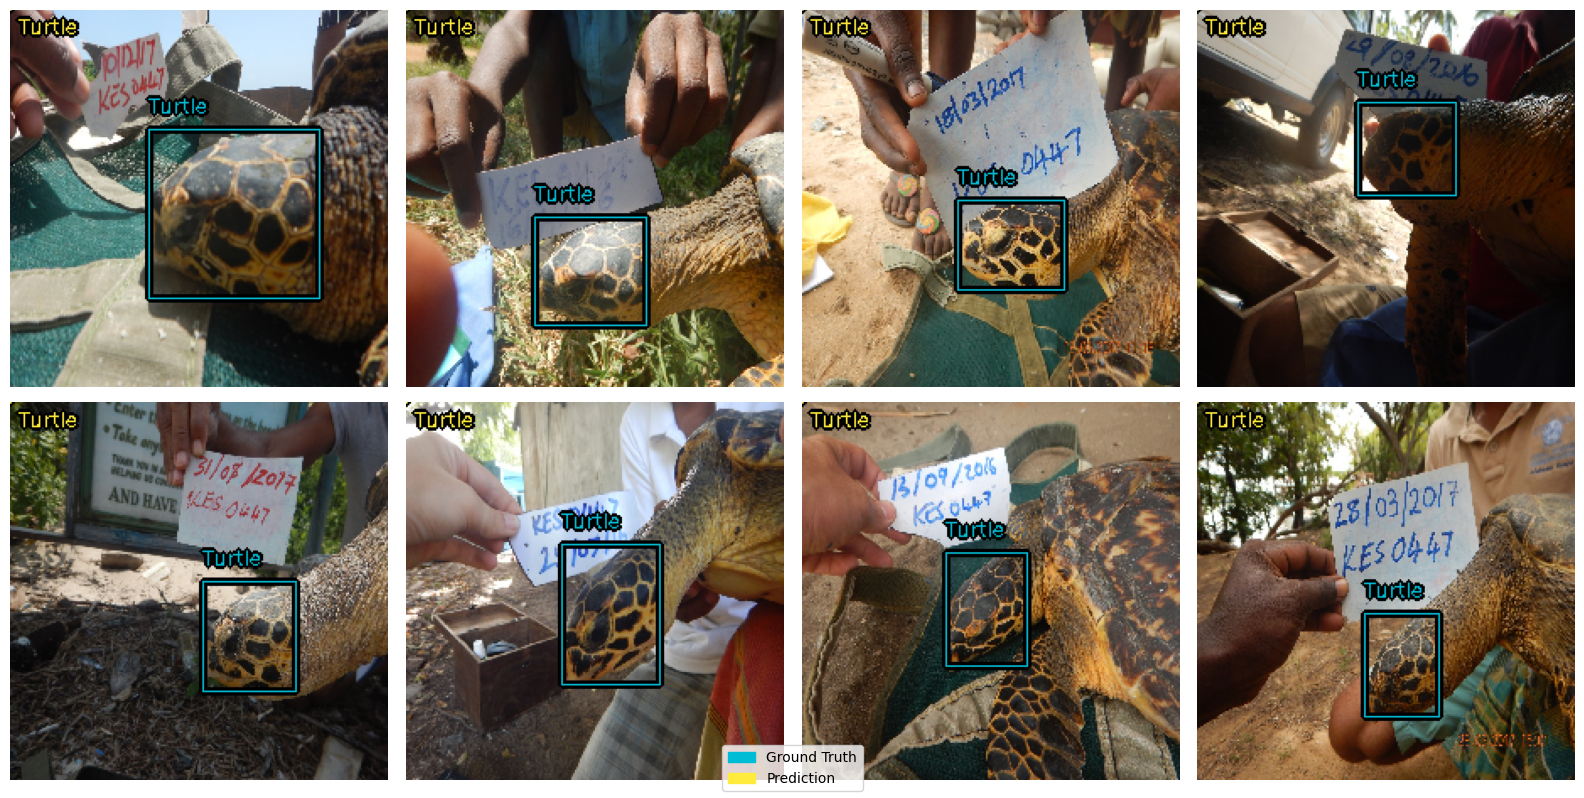

In [69]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

backbone = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=[224,224,3], weights='imagenet')

model = Model(backbone)

model.load_weights('./models/no_anchor_EffnetB0.tf')

model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=False,
    iou_threshold=0.2,
    confidence_threshold=0.1,
    max_detections=1
)

print(f'Detections over validation set')

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xyxy")


In [70]:
name = 'no_anchor_EffnetB0'

backbone = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=[224,224,3], weights='imagenet')

model = Model(backbone)

model.load_weights('./models/no_anchor_EffnetB0.tf')

model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=False,
    iou_threshold=0.5,
    confidence_threshold=0,
    max_detections=1
)

iou = 0
samples = 0
for image, label in visualization_ds:
    samples += tf.shape(image)[0]
    pred = model.predict(image)['boxes']
    pred = tf.reshape(pred, [-1,4]) * INPUT_SIZE_LEARNER
    label = label['boxes']
    label = tf.reshape(label, [-1,4])
    iou += compute_iou(pred,label)

iou = iou / tf.cast(samples, tf.float32)
print(f'IoU for model {name} is: {iou}')

1/1 [==============================] - 0s 14ms/step
IoU for model no_anchor_EffnetB0 is: 0.6181758046150208


***

## Inference on the test dataset

We can finally perform the prediction over the test set so that it can be evalutated on the Test dataset used by Zindi.

First of all, we need to read the file containing the Images for which we need to perform the prediction as a pandas dataset.

In [71]:
ss = pd.read_csv('./dataset/SampleSubmission.csv')
ss.head(3)

Image_ID  x  y  w  h
0  4863D911  0  0  0  0
1  6DD3ADD5  0  0  0  0
2  E8DC4D6A  0  0  0  0

Given the file names, using the load_dataset() function, we load the test dataset ready for the inference stage.

In [72]:
test_dataset,_  = load_dataset(training=False)
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

[INFO] loading dataset...
[INFO] dataset loaded.


Now we define the Non Maximum Suppression layer for the processing of the prediction of the network.

In [73]:
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
    max_detections=1
)

We perform now the prediction with the network and scale it down to the range [0,1] since this is the format required for the solution.

In [75]:
predictions = tf.reshape(tf.constant([]), [-1,4])

for image, size in test_dataset:
    size = tf.cast(size, tf.float32)
    pred = model.predict(image)['boxes']
    pred = tf.reshape(pred, [-1,4])
    x1 = pred[:,0]
    x2 = pred[:,2]
    y1 = pred[:,1]
    y2 = pred[:,3]
    
    w = x2 - x1
    h = y2 - y1
    
    batch_preds = tf.reshape(tf.stack([x1,y1,w,h], axis=1), [-1,4])
    predictions = tf.concat([predictions,batch_preds], axis=0)

ss.loc[:,['x', 'y', 'w', 'h']] = np.array(predictions)

1/1 [==============================] - 0s 463ms/step


In [76]:
ss.head()
ss.loc[ss['Image_ID'] == 'A94BA02F']

Image_ID         x         y         w         h
330  A94BA02F  0.218637  0.350933  0.299143  0.449111

Finally, we can write our predictions to a .csv file

In [77]:
ss.to_csv(f'.\submissions\Submission_{name}.csv', index=False)

In [78]:
sub = pd.read_csv(f'.\submissions\Submission_{name}.csv')
sub.head()

Image_ID         x         y         w         h
0  4863D911  0.275629  0.335381  0.401815  0.474184
1  6DD3ADD5  0.331842  0.380887  0.383210  0.385915
2  E8DC4D6A  0.409645  0.494598  0.384398  0.494748
3  E02ABB6C  0.376434  0.478973  0.387608  0.501401
4  875C19F4  0.357850  0.437787  0.410093  0.449149